# Simple Logistic Regression Pipeline Using PySpark

> I am pretty new to the PySpark framework so I am putting this quick notebook together to build off of for future competitions. In this notebook I perform a quick EDA and take a spark dataframe through a simple logistic regression pipeline 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


In [2]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=841dd215d09a5734f3d645c7a005f4e27d5d24b02f4c4e1474e85fe443e16892
  Stored in directory: /root/.cache/pip/wheels/5a/54/9b/a89cac960efb57c4c35d41cc7c9f7b80daa21108bc376339b7
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType

In [4]:
spark = (SparkSession.builder.master("local[*]")
                    .config('spark.driver.maxResultSize', 0)
                    .config("spark.driver.memory","16g")
                    .config("spark.sql.shuffle.partitions",20)
                    .appName('PlaygroundS3E8')
                    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/27 23:33:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#SET FILEPATHS
train_fp = "../input/playground-series-s3e7/train.csv"
test_fp = "../input/playground-series-s3e7/test.csv"

In [6]:
train_pd = pd.read_csv(train_fp)

In [7]:
train_pd.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [8]:
train_pd['booking_status'].value_counts()

0    25596
1    16504
Name: booking_status, dtype: int64

In [9]:
train_pd['arrival_year'].value_counts()

2018    36050
2017     6050
Name: arrival_year, dtype: int64

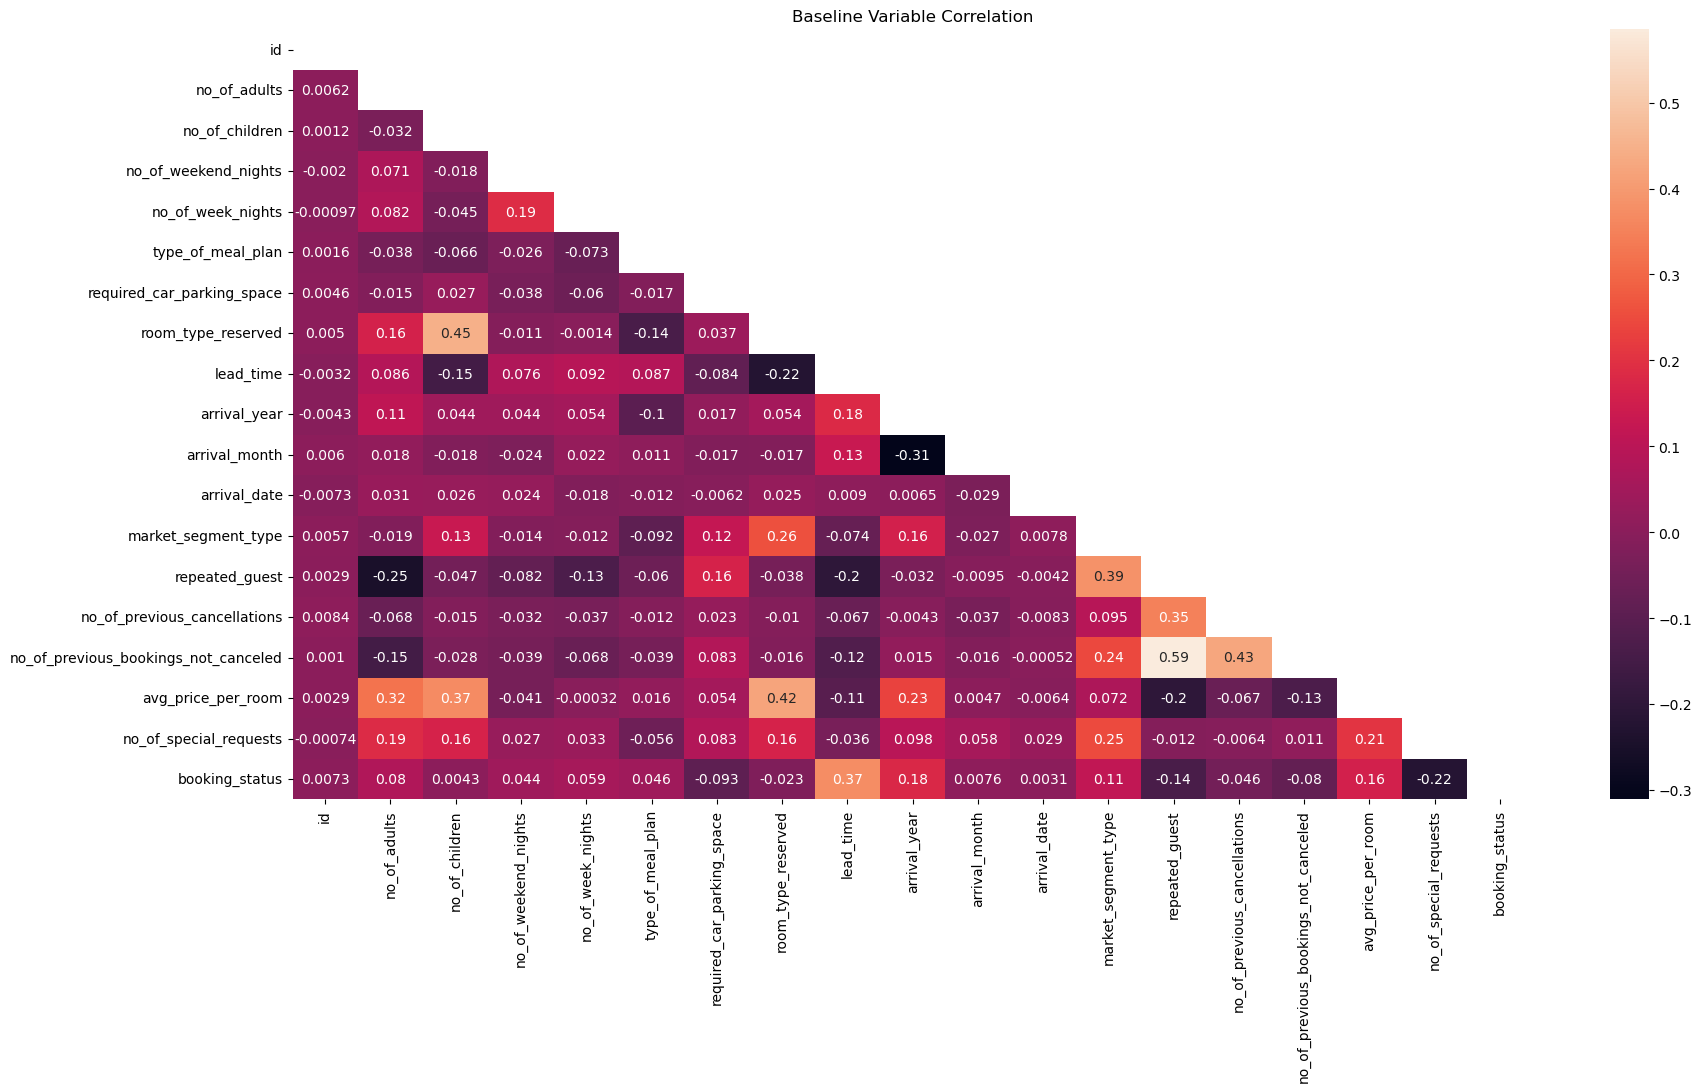

In [10]:
interaction_cols = train_pd.columns
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(train_pd[interaction_cols].corr()))
sns.heatmap(train_pd[interaction_cols].corr(),annot=True,mask=mask).set(title='Baseline Variable Correlation')
plt.show()

# Read Spark Dataframes

In [11]:
#INFER SCHEMA = TRUE PREVENTS THE NEED TO WRITE OUT THE ENTIRE SCHEMA AS A DATA STRUCTURE. WORKS WELL FOR CLEAN KAGGLE DATA :) 
train_df = spark.read.csv(train_fp, inferSchema=True, header=True)
test_df = spark.read.csv(test_fp, inferSchema=True, header=True)

In [12]:
#SIMILAR TO PD.HEAD()
train_df.show(5)

+---+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
| id|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+---+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----

In [13]:
#ENSURE THAT INFERRED SCHEMA COMES OUT AS EXPECTED
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- no_of_adults: integer (nullable = true)
 |-- no_of_children: integer (nullable = true)
 |-- no_of_weekend_nights: integer (nullable = true)
 |-- no_of_week_nights: integer (nullable = true)
 |-- type_of_meal_plan: integer (nullable = true)
 |-- required_car_parking_space: integer (nullable = true)
 |-- room_type_reserved: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: integer (nullable = true)
 |-- repeated_guest: integer (nullable = true)
 |-- no_of_previous_cancellations: integer (nullable = true)
 |-- no_of_previous_bookings_not_canceled: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: integer (nullable = true)
 |-- booking_status: integer (nullable = true)



In [14]:
train_df = train_df.withColumn("arrival_year",col("arrival_year").cast(StringType())).withColumn("arrival_month",col("arrival_month").cast(StringType())).withColumn("arrival_date",col("arrival_date").cast(StringType()))
test_df = test_df.withColumn("arrival_year",col("arrival_year").cast(StringType())).withColumn("arrival_month",col("arrival_month").cast(StringType())).withColumn("arrival_date",col("arrival_date").cast(StringType()))

# String Indexer

> In this section I am taking the features associated with date and making them one hot encoded variables instead of ordinal variables

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [16]:
categorical_cols = ['arrival_year', 'arrival_month', 'arrival_date']
index_output_cols = [x + "Index" for x in categorical_cols]
ohe_output_cols = [x + "OHE" for x in categorical_cols]

In [17]:
string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid='skip')
ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

# Feature Assembler

> Now I am taking the one hot encoded variables and adding them to the numeric columns to make a final feature assembler to feed into the model fit stage

In [18]:
from pyspark.ml.feature import VectorAssembler

numeric_cols = [field for (field, dataType) in train_df.dtypes if (((dataType == "integer") | (dataType == "double")) & (field != "booking_status") & (field != 'id'))]
assembler_input = ohe_output_cols + numeric_cols
vec_assembler = VectorAssembler(inputCols=assembler_input, outputCol="features")

# Create Validation Sample

> Below I am creating a hold out set to test the out of sample AUC

In [19]:
X_train, X_test = train_df.randomSplit([0.8, 0.2], seed=42)

In [20]:
print("Training Size: ", X_train.count())
print("Validation Size: ", X_test.count())

Training Size:  33672
Validation Size:  8428


# Logistic Regression Model

In [21]:
from pyspark.ml.classification import LogisticRegression

In [22]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'booking_status', maxIter=10)

# Create Pipeline

In [23]:
from pyspark.ml import Pipeline

stages = [string_indexer, ohe_encoder, vec_assembler, lr]
pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(X_train)

# Saving Your Model

In [24]:
#FEED THE NAME OF THE FILE YOU WANT FOR KAGGLE NOTEBOOK OUTPUT
pipeline_model.write().overwrite().save('lr_1')

# Loading Model

In [25]:
from pyspark.ml import PipelineModel

saved_pipeline_model = PipelineModel.load('lr_1')

# Apply Model to Validation Set

In [26]:
pred_df = saved_pipeline_model.transform(X_test)

In [27]:
pred_df.select("features", "booking_status", "prediction").toPandas().head()

,features,booking_status,prediction
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,0.0
1,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1.0
2,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0
3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,1.0
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.0


In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

regression_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="booking_status", metricName='areaUnderROC')

In [29]:
#BASELINE AUC
auc = regression_evaluator.evaluate(pred_df)

print(f"AUC is {auc}")

AUC is 0.6027458804430166


# Add Cross Validation Strategy

In [30]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [31]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.threshold, [0.3, 0.4, 0.5, 0.6, 0.7]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=regression_evaluator,
                          numFolds=3) 

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(X_train)


In [32]:
prediction = cvModel.transform(X_test)

auc = regression_evaluator.evaluate(prediction)

print(f"CV AUC is {auc}")

CV AUC is 0.6328468916150359


> The improved validation score is 0.6328. This score is very close to what was shown on the leaderboard for this particular submission.

## Submit

In [33]:
#CREATE FINAL PREDICTIONS
prediction = cvModel.transform(test_df)
predictions = prediction.select("features", "prediction").toPandas()["prediction"]

In [34]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
submission['booking_status'] = predictions
submission.to_csv('pyspark_lr_2.csv', index=False)

# CV On All Training Data

In [35]:
#NOW TRAIN ON ENTIRE TRAINING SET
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.threshold, [0.3, 0.4, 0.5, 0.6, 0.7]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=regression_evaluator,
                          numFolds=3) 

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_df)

In [36]:
prediction = cvModel.transform(X_test)

auc = regression_evaluator.evaluate(prediction)

print(f"FULL TRAIN CV AUC is {auc}")

FULL TRAIN CV AUC is 0.6324727827081691


In [37]:
#CREATE FINAL PREDICTIONS
prediction = cvModel.transform(test_df)
predictions = prediction.select("features", "prediction").toPandas()["prediction"]

In [38]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
submission['booking_status'] = predictions
submission.to_csv('pyspark_lr_3.csv', index=False)

# Create Submission With Saved Model

In [39]:
out_df = saved_pipeline_model.transform(test_df)

In [40]:
predictions = out_df.select("features", "prediction").toPandas()["prediction"]

In [41]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
submission['booking_status'] = predictions

submission.to_csv('pyspark_lr_1.csv', index=False)